# Fixpoint Quantization and Overflow #

This notebook shows how to (re-)quantize signals in Python using the Python toolbox migen 

<img src="img/migen_logo_100dpi.png" alt="migen logo"/> 

This toolbox ...

In [1]:
import os, sys
import time

module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)

import dsp_nmigen.pyfda_fix_lib as fx

%matplotlib inline    
import matplotlib.pyplot as plt

plt.style.use('script.mplstyle')
import numpy as np

figsize = {"figsize":(13,7)}

The migen `requant()` function has been written to facilitate reducing and expanding the number of integer and fractional bits.

**In the designer's head, input and output word can be assumed to be aligned at their binary points.**

The following shows an example of rescaling an input word from Q2.4 to Q0.3
using wrap-around and truncation. It's easy to see that for simple wrap-around
logic, the sign of the result may change.

      S | WI1 | WI0 * WF0 | WF1 | WF2 | WF3  :  WI = 2, WF = 4, W = 7
      0 |  1  |  0  *  1  |  0  |  1  |  1   =  43 (dec) or 43/16 = 2 + 11/16 (float)
                    *
              |  S  * WF0 | WF1 | WF2        :  WI = 0, WF = 3, W = 4
                 0  *  1  |  0  |  1         =  7 (dec) or 7/8 (float)

For the actual conversion calculations both words are right aligned. Changes in the number of integer bits `dWI` and fractional
bits `dWF` are handled separately.

Finally, the corresponding float or "real (world) value" is calculated by multiplying the integer 
value by 2 ** (-WF).

### Fractional Bits

- Reducing the number of bits by `dWF`:
  - For truncating the number of fractional bits ("floor"), right-shift by `dWF`. Unused bits are discarded.
  
  - For rounding, add '1' to the bit below the truncation point before right-shifting. 
  
  - For round-towards-zero ("fix"), add the sign bit to the LSB, then truncate below the LSB

- Extend the number of fractional bits by left-shifting the integer by `dWF`,
  LSB's are filled with zeros.

### Integer Bits


- For reducing the number of integer bits ("wrap") by `dWI`, simply discard `dWI` bits from the right (MSB side). This can create an unwanted sign reversal.
  
- Saturation logic ("sat") is achieved by testing the input word against minimum and maximum value before discarding the bits on MSB side.

- The number of integer bits is SIGN-EXTENDED by filling up the left-most bits with the sign bit.

Run time:	1e+03 ms for 10000 quantizations



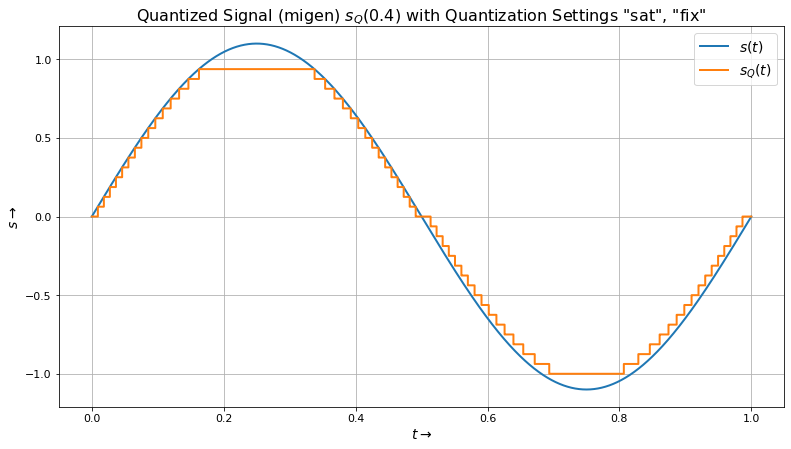

In [7]:
from migen import Signal, Module, run_simulation
from migen.fhdl import verilog
from dsp_migen.requant import requant

N = 10000; f_a = 1
t = np.linspace(0, 1, N, endpoint=False)
s = 1.1 * np.sin(2 * np.pi * f_a * t)

qI_dict = {'WI':1, 'WF': 5, 'quant':'fix', 'ovfl': 'sat'} # input quantization dict ('quant' and 'sat' settings are not used here)
qO_dict = {'WI':0, 'WF': 4, 'quant':'fix', 'ovfl': 'sat'} # output quantization dict

class Quant_migen(Module):
    """ This module only demonstrates the requant function. """
    def __init__(self):
        # ------------- Define I/Os -------------------------------------------
        self.i = Signal((qI_dict['WI'] + qI_dict['WF'] + 1, True)) # signed input signal
        self.o = Signal((qO_dict['WI'] + qO_dict['WF'] + 1, True)) # output signal

        # requantize from input to output format
        self.comb += self.o.eq(requant(self, self.i, qI_dict, qO_dict))

Q1 = Quant_migen() # instantiate migen object

def tb(stimulus,  outputs):
    """ testbench generator with a stimulus list as input to migen module """
    for x in stimulus:
        yield Q1.i.eq(int(x)) # pass one stimulus value to filter
        outputs.append((yield Q1.o)) # append filter output to output list
        yield # next x until stimulus is processed

sq_mig = [] # initialize list for response
# initialize testbench generator; stimulus and response are integers!
# convert to float and back by dividing / multiplying with 2 ** WF
testbench = tb(s*2**qI_dict['WF'], sq_mig)  # stimulus, response
# uncomment to generate verilog
# print(verilog.convert(Q1, ios={Q1.i, Q1.o}))

t_cpu = time.perf_counter()
run_simulation(Q1, testbench) # run_simulation expects a migen module and a generator
print('Run time:\t{0:.3g} ms for {1} quantizations\n'.format((time.perf_counter()-t_cpu)*1000, len(s)))
#
fig1, ax1 = plt.subplots(**figsize); ax1.grid(True)
ax1.set_title('Quantized Signal (migen) $s_Q$({0}.{1}) with Quantization Settings "{2}", "{3}"'\
              .format(qO_dict['WI'], qO_dict['WF'], qO_dict['ovfl'], qO_dict['quant']))
ax1.plot(t, s, label = r'$s(t)$', lw=2)
# migen returns a list of integers which must be scaled by 2^(-WF)
ax1.step(t, np.asarray(sq_mig) / (1 << qO_dict['WF']) , where = 'post', label = r'$s_Q(t)$', lw=2)
#ax1.plot(t, s-sq_mig, label = r'$\epsilon(t) = s(t) - s_Q(t)$', lw=2)
ax1.legend(fontsize = 14)
ax1.set_xlabel(r'$t \rightarrow$'); ax1.set_ylabel(r'$s \rightarrow$');

***
### Copyright

(c) 2016 - 2020 Christian Münker 

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources) , feel free to use it for your own purposes. Please attribute the work as follows: *Christian Münker, dsp_migen documentation*.